# Time Series

In [4]:
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns
import ruptures as rpt
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

import warnings; warnings.simplefilter('ignore')
%matplotlib inline
sns.set()

## Functions

In [5]:
# Assumes yellow and green df have the same columns but not necessarily same names
def combine_yellow_green(y_df, g_df):
    y = y_df.copy()
    g = g_df.copy()
    g.columns = y.columns
    y['cab_type'] = 'yellow'
    g['cab_type'] = 'green'
    taxi_df = pd.concat([y, g], axis=0).reset_index(drop=True)
    return taxi_df

In [28]:
def prep_Prophet(df, col_date):
    df_ts = pd.DataFrame(df[col_date].value_counts()).reset_index().rename(columns={'index': 'ds',
                                                                                  col_date: 'y'})
    return df_ts.sort_values('ds')

In [108]:
def create_ts_vars(df, col_date):
    df["month"] = df[col_date].dt.month
    df["yearday"] = df[col_date].dt.strftime("%j")
    df["day"] = pd.to_datetime(df[col_date].dt.date)
    df["monthday"] =  df[col_date].dt.day
    df["hour"] = df[col_date].dt.hour
    df["weekday"] = df[col_date].dt.weekday_name
    df["dt_hour"] = df[col_date].dt.floor('H')
    return df

In [8]:
def check_time_cont(df, col_date, timeframe_lst, freq):
    start = pd.to_datetime(timeframe_lst[0])
    end = pd.to_datetime(timeframe_lst[1])
    datelist = pd.date_range(start, end, freq=freq, closed='left').tolist()
    df_datelist = df.sort_values(col_date)[col_date].tolist()
    no_rep = [x for x in datelist if x not in df_datelist]
    if len(no_rep) == 0:
        print("All time frames represented")
        return no_rep
    else:
        print("Not all time frames represented")
        return no_rep

In [36]:
def combine_uber_taxi(uber_df, taxi_df, colnames):
    merge_df = pd.merge(uber_df, taxi_df,
                        on='ds', how='left',
                        suffixes=('_uber', '_taxi'))
    merge_df = merge_df.rename(columns={'ds': colnames[0],
                             'y_uber': colnames[1],
                            'y_taxi': colnames[2]})
    return merge_df

## Read in data

In [2]:
uber = pd.read_csv("data/uber_2014_NTA.csv",
                  parse_dates=["pickup_datetime"])

In [10]:
# # Code to combine yellow and green cab data
# yellow = pd.read_csv("data/yellow_cabs_NTA.csv",
#                      parse_dates=["pickup_datetime", "dropoff_datetime"])

# green = pd.read_csv("data/green_trips_NTA_coded.csv",
#                      parse_dates=["pickup_datetime", "dropoff_datetime"])

# taxi_df = combine_yellow_green(yellow, green)
# taxi_df.to_csv("data/taxi.csv", index=False)

In [16]:
taxi = pd.read_csv("data/taxi.csv",
                   parse_dates=["pickup_datetime", "dropoff_datetime"])

## Prepare data for analysis

In [109]:
uber_ts = create_ts_vars(uber, 'pickup_datetime')

In [110]:
taxi_ts = create_ts_vars(taxi, "pickup_datetime")

Is every day represented in taxi data?

In [115]:
taxi_day = prep_Prophet(taxi_ts, 'day')
no_rep = check_time_cont(taxi_day, 'ds', ["2014-04-01", "2014-10-01"], 'D')

All time frames represented


Every hour?

In [116]:
taxi_hr = prep_Prophet(taxi_ts, 'dt_hour')
no_rep = check_time_cont(taxi_hr, 'ds', ["2014-04-01", "2014-10-01"], 'H')

All time frames represented


How about in Uber data?

In [117]:
uber_day = prep_Prophet(uber_ts, 'day')
no_rep = check_time_cont(uber_day, 'ds', ["2014-04-01", "2014-10-01"], 'D')

All time frames represented


In [118]:
uber_hr = prep_Prophet(uber_ts, 'dt_hour')
no_rep = check_time_cont(uber_hr, 'ds', ["2014-04-01", "2014-10-01"], 'H')

Not all time frames represented


In [27]:
no_rep

[Timestamp('2014-09-30 23:00:00', freq='H')]

Only the last hour of September 30, 2014 is not represented in Uber data - likely because of a data cut-off, not that there weren't any rides

### Create combined df

In [188]:
combined_hr_count = combine_uber_taxi(uber_hr, taxi_hr, colnames=['date_hour', 'uber_count', 'taxi_count'])
long_combined_hr = pd.melt(combined_hr_count, id_vars=['date_hour'], var_name='type', value_name='count')
combined_hr = create_ts_vars(long_combined_hr, "date_hour")

In [189]:
combined_hr.head()

,date_hour,type,count,month,yearday,day,monthday,hour,weekday,dt_hour
0,2014-04-01 00:00:00,uber_count,149,4,091,2014-04-01,1,0,Tuesday,2014-04-01 00:00:00
1,2014-04-01 01:00:00,uber_count,71,4,091,2014-04-01,1,1,Tuesday,2014-04-01 01:00:00
2,2014-04-01 02:00:00,uber_count,32,4,091,2014-04-01,1,2,Tuesday,2014-04-01 02:00:00
3,2014-04-01 03:00:00,uber_count,108,4,091,2014-04-01,1,3,Tuesday,2014-04-01 03:00:00
4,2014-04-01 04:00:00,uber_count,217,4,091,2014-04-01,1,4,Tuesday,2014-04-01 04:00:00


In [190]:
tmp_combined_day = pd.DataFrame(long_combined_hr.groupby(['day', 'type'])['count'].sum().reset_index())
combined_day = create_ts_vars(tmp_combined_day, "day")

In [191]:
combined_day["weekday_num"] = combined_day.day.dt.weekday

In [192]:
combined_weekday = pd.DataFrame(combined_day.groupby(['weekday_num', 'type'])
                                ['count'].sum().reset_index())

In [193]:
combined_weekday.head()

,weekday_num,type,count
0,0,taxi_count,636249
1,0,uber_count,524866
2,1,taxi_count,718785
3,1,uber_count,609570
4,2,taxi_count,745781


# EDA + Visualization

### Uber and Taxi Rides by day

In [255]:
Sat = combined_day[combined_day.weekday=='Saturday']

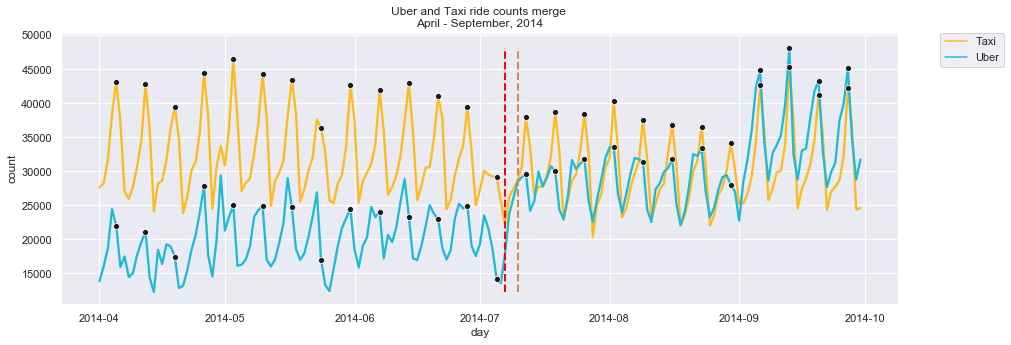

In [274]:
pal = {"uber_count": "#1EBAD6", "taxi_count": "#FEBB1B"}
fig_day = plt.figure(figsize=(15, 5))
ax = sns.lineplot(x='day', y='count',
                 hue='type',
                 palette=pal,
                  linewidth=2.3,
                 data=combined_day, zorder=1)
# Put the legend out of the figure
handles, labels = ax.get_legend_handles_labels()
labels = ["", "Taxi", "Uber"]
ax.legend(handles[1:], labels[1:],
          bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set(xlabel='Day', title="Uber and Taxi ride counts merge \nApril - September, 2014")
min_count = min(combined_day["count"])
max_count = max(combined_day["count"])
ax.plot([pd.to_datetime("2014-07-07"), pd.to_datetime("2014-07-07")],
        [min_count, max_count],
        linewidth=2, linestyle='dashed',
       color='red')
ax.plot([pd.to_datetime("2014-07-10"), pd.to_datetime("2014-07-10")],
        [min_count, max_count],
        linewidth=2, linestyle='dashed')
sns.scatterplot(x='day', y='count',
#             hue='type',
            marker='o',
            color='k',
            data=Sat,legend=False, zorder=2)
plt.show()

In [275]:
fig_day.savefig("trend_over_time.png")

### Trends over day of the week

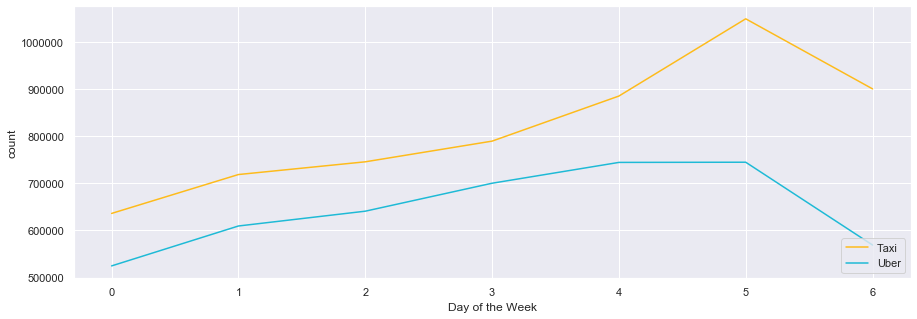

In [199]:
fig_weekday = plt.figure(figsize=(15, 5))
ax = sns.lineplot(x='weekday_num', y='count',
                 hue='type',
                 palette=pal,
                 data=combined_weekday)
handles, labels = ax.get_legend_handles_labels()
labels = ["", "Taxi", "Uber"]
ax.legend(handles[1:], labels[1:],
          loc="lower right")
ax.set(xlabel='Day of the Week', title="")
plt.show()

In [390]:
# fig_weekday.savefig("trend_over_week.png")

In [200]:
after_event = combined_day[combined_day["day"] >= pd.to_datetime("2014-07-07")]
after_weekday = pd.DataFrame(after_event.groupby(['weekday_num', 'type'])
                                ['count'].sum().reset_index())

In [276]:
before_event = combined_day[combined_day["day"] < pd.to_datetime("2014-07-07")]
before_weekday = pd.DataFrame(before_event.groupby(['weekday_num', 'type'])
                                ['count'].sum().reset_index())

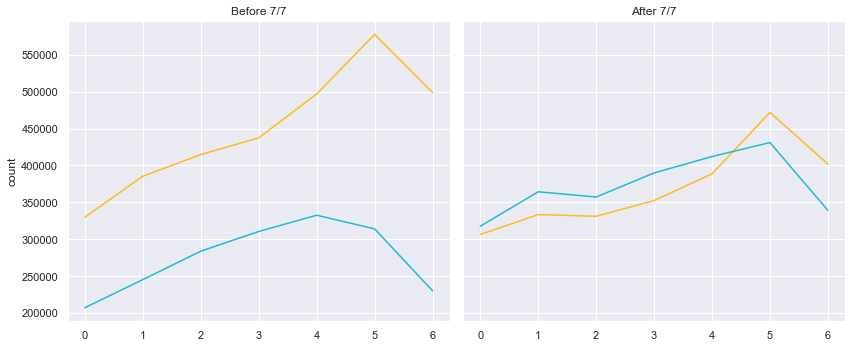

In [340]:
f, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
sns.lineplot(x='weekday_num', y='count',
                 hue='type',
                 palette=pal,
                 data=before_weekday,
                 legend=False, ax=axes[0]).set(xlabel='', title="Before 7/7")
sns.lineplot(x='weekday_num', y='count',
                 hue='type',
                 palette=pal,
                 data=after_weekday,
                 legend=False, ax=axes[1]).set(xlabel='', title="After 7/7")
plt.tight_layout()
plt.show()

In [341]:
f.savefig('weekday_compare.png')

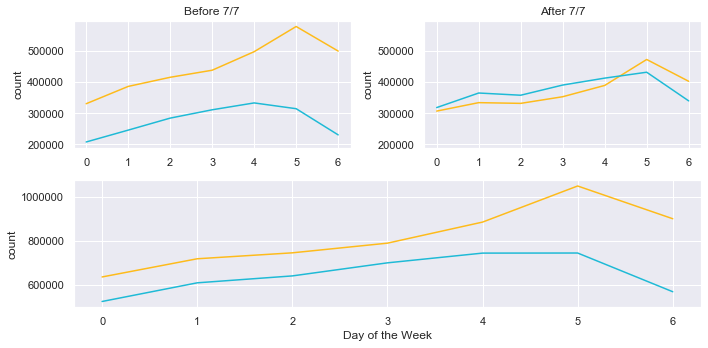

In [322]:
fig_weekday = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(212)
ax = sns.lineplot(x='weekday_num', y='count',
                 hue='type',
                 palette=pal,
                 data=combined_weekday, ax=ax1, legend=False).set(xlabel='Day of the Week')
ax2 = plt.subplot(221)
sns.lineplot(x='weekday_num', y='count',
                 hue='type',
                 palette=pal,
                 data=before_weekday,
                 legend=False, ax=ax2).set(xlabel='', title="Before 7/7")
ax3 = plt.subplot(222, sharey=ax2)
sns.lineplot(x='weekday_num', y='count',
                 hue='type',
                 palette=pal,
                 data=after_weekday,
                 legend=False, ax=ax3).set(xlabel='', title="After 7/7")
plt.tight_layout()
plt.show()

In [323]:
fig_weekday.savefig("subplot_weekday.png")

## Can we detect the change in trend over time?

In [389]:
uber_daycount = combined_day[combined_day.type=='uber_count']['count']

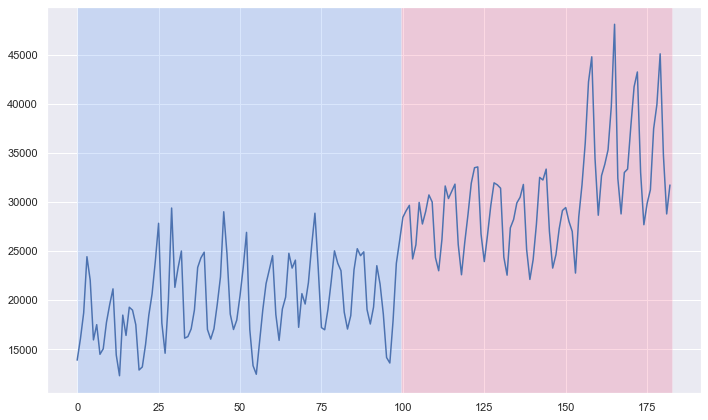

In [252]:
alg = rpt.Pelt(model="rbf").fit(uber_daycount.values)
result = alg.predict(pen=10)
detect_changepoint = rpt.display(uber_daycount, result, figsize=(10, 6))
plt.savefig("changepoint.png")
plt.show()

In [223]:
combined_day[combined_day.type=='uber_count'].iloc[100]

day            2014-07-10 00:00:00
type                    uber_count
count                        28435
month                            7
yearday                        191
monthday                        10
hour                             0
weekday                   Thursday
dt_hour        2014-07-10 00:00:00
weekday_num                      3
Name: 201, dtype: object

# Fitting a time series model

## Uber time series

In [333]:
uber_hr = combined_hr_count[['date_hour', 'uber_count']]
uber_prophet = combined_hr_count[['date_hour', 'uber_count']].rename(columns={'date_hour':'ds',
                                                              'uber_count':'y'})

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


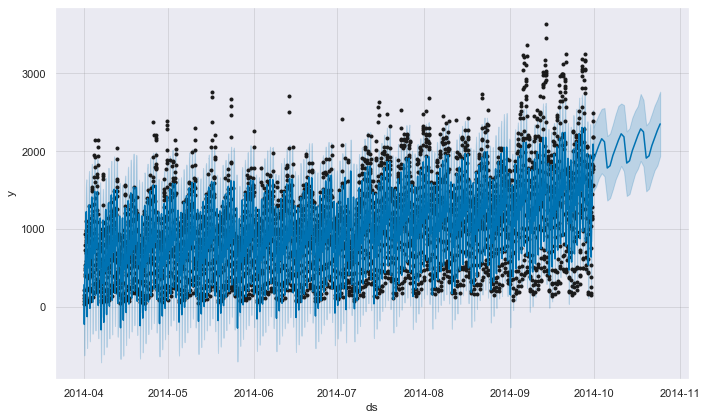

In [334]:
uber_model = Prophet()
uber_model.add_country_holidays(country_name='US')
uber_model.train_holiday_names
uber_model.fit(uber_prophet)

future_dates = uber_model.make_future_dataframe(periods=24)
uber_forecast = uber_model.predict(future_dates)
uber_model.plot(uber_forecast, uncertainty=True)
plt.show()

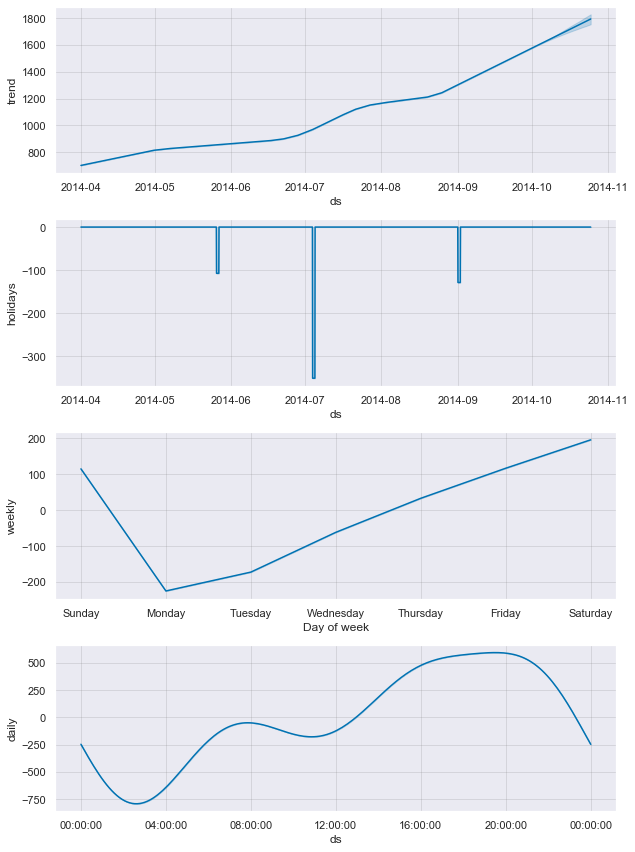

In [335]:
uber_model.plot_components(uber_forecast)
plt.show()

## Fit a model for Taxis

In [336]:
taxi_hr = combined_hr_count[['date_hour', 'taxi_count']]
taxi_prophet = taxi_hr.rename(columns={'date_hour':'ds',
                                        'taxi_count':'y'})

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


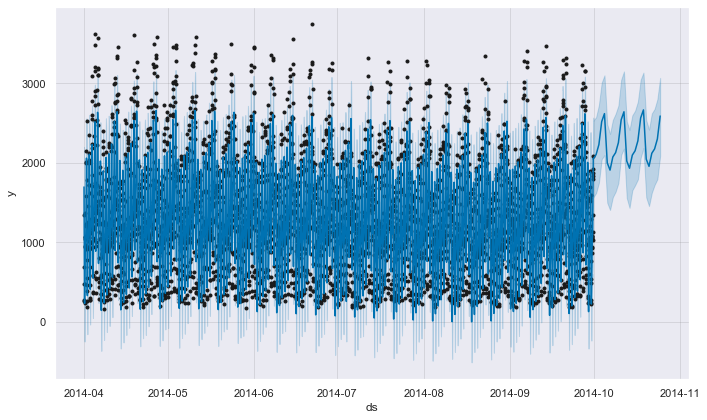

In [337]:
taxi_model = Prophet()
taxi_model.add_country_holidays(country_name='US')
taxi_model.train_holiday_names
taxi_model.fit(taxi_prophet)

future_dates = taxi_model.make_future_dataframe(periods=24)
forecast = taxi_model.predict(future_dates)
taxi_model.plot(forecast, uncertainty=True)
plt.show()

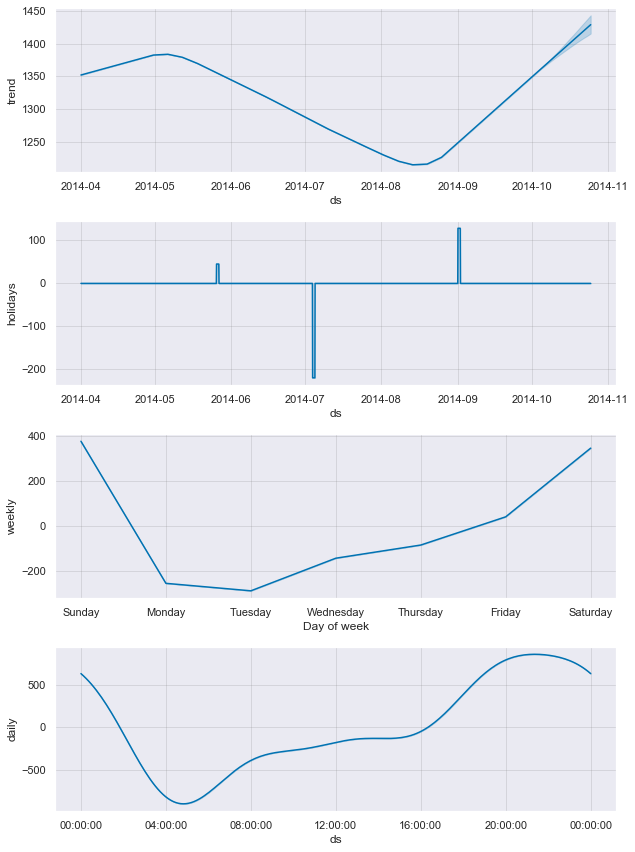

In [338]:
taxi_model.plot_components(forecast)
plt.show()

# Case Study: BK38

In [348]:
hr_NTA = pd.read_csv("Data/merged_hr_NTA.csv", parse_dates=["dt_hour"])

In [352]:
long_hr_NTA = pd.melt(hr_NTA, id_vars=['pickup_NTA','dt_hour'],
                      var_name='type', value_name='count')

In [357]:
bk38 = long_hr_NTA[long_hr_NTA.pickup_NTA == 'BK38']

In [359]:
bk38_ts = create_ts_vars(bk38, 'dt_hour')

In [361]:
bk38_ts["weekday_num"] = bk38_ts.dt_hour.dt.weekday

In [362]:
bk38_ts.head()

,pickup_NTA,dt_hour,type,count,month,yearday,day,monthday,hour,weekday,weekday_num
32602,BK38,2014-04-01 00:00:00,uber_count,2.0,4,091,2014-04-01,1,0,Tuesday,1
32603,BK38,2014-04-01 01:00:00,uber_count,2.0,4,091,2014-04-01,1,1,Tuesday,1
32604,BK38,2014-04-01 02:00:00,uber_count,1.0,4,091,2014-04-01,1,2,Tuesday,1
32605,BK38,2014-04-01 03:00:00,uber_count,4.0,4,091,2014-04-01,1,3,Tuesday,1
32606,BK38,2014-04-01 04:00:00,uber_count,5.0,4,091,2014-04-01,1,4,Tuesday,1


In [363]:
bk_weekday = pd.DataFrame(bk38.groupby(['weekday_num', 'type'])
                                        ['count'].sum().reset_index())

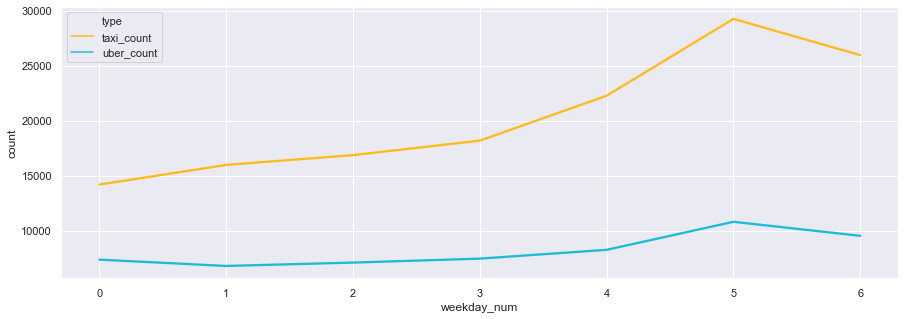

In [372]:
fig_day = plt.figure(figsize=(15, 5))
sns.lineplot(x='weekday_num', y='count',
                 hue='type',
                 palette=pal,
                linewidth=2.3,
                 data=bk_weekday)

In [376]:
bk38_after = bk38[bk38.dt_hour >= pd.to_datetime("2014-07-07")]

In [ ]:
bk_weekday = pd.DataFrame(bk38.groupby(['weekday_num', 'type'])
                                        ['count'].sum().reset_index())


In [377]:
bk_hr = pd.DataFrame(bk38.groupby(['hour', 'type'])
                                 ['count'].sum().reset_index())
bk_hr_after = pd.DataFrame(bk38_after.groupby(['hour', 'type'])
                                 ['count'].sum().reset_index())

[Text(0.5, 17.200000000000003, 'Hour'), Text(0.5, 1, '')]

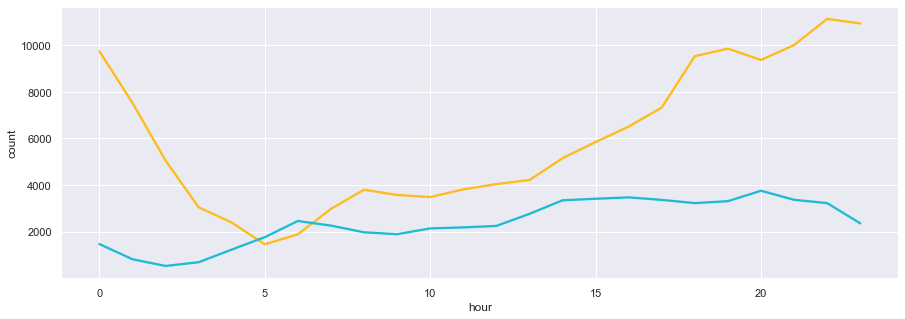

In [384]:
pal = {"uber_count": "#1EBAD6", "taxi_count": "#FEBB1B"}
fig_hr = plt.figure(figsize=(15, 5))
sns.lineplot(x='hour', y='count',
             hue='type',
             palette=pal,
             linewidth=2.3,
             data=bk_hr,legend=False)
ax.set(xlabel='Hour', title="")

In [381]:
fig_hr.savefig("bk38_overall_hr.png")

[Text(0.5, 0, 'Hour'), Text(0.5, 1.0, 'Trend after 7/7')]

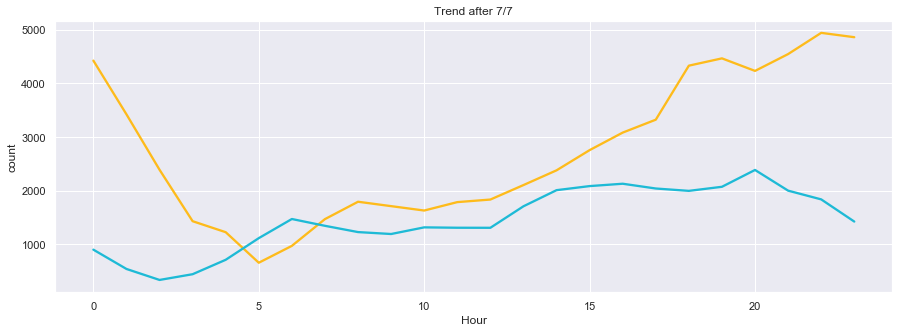

In [387]:
fig_hr_after = plt.figure(figsize=(15, 5))
ax = sns.lineplot(x='hour', y='count',
             hue='type',
             palette=pal,
             linewidth=2.3,
             data=bk_hr_after,legend=False)
ax.set(xlabel='Hour', title="Trend after 7/7")

In [388]:
fig_hr_after.savefig("bk38_overall_hr_after.png")

# Other

## Create merged df for Jie's mapping

In [266]:
taxi_hr_NTA = pd.DataFrame({'taxi_count' : taxi_ts.groupby( [ "pickup_NTA", "dt_hour"] ).size()}).reset_index()

In [264]:
uber_hr_NTA = pd.DataFrame({'uber_count' : uber_ts.groupby( [ "NTA", "dt_hour"] ).size()})\
                .reset_index().rename(columns={'NTA': 'pickup_NTA'})

In [269]:
merged_hr_NTA = uber_hr_NTA.merge(taxi_hr_NTA, on=['dt_hour', 'pickup_NTA'], how='outer')

In [271]:
merged_hr_NTA = merged_hr_NTA.fillna(0)

In [273]:
# merged_hr_NTA.to_csv("merged_hr_NTA.csv", index=False)